In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from abc import ABC, abstractmethod
import torch
import torch.nn as nn
from deepshape.curves import *
from torch.nn.functional import mse_loss

In [139]:
class ShapeDistance(nn.Module):
    def __init__(self, q, r, k=128):
        super().__init__()
        self.q = q
        self.r = r
        self.X = torch.linspace(0, 1, k).reshape(-1, 1)
        
             
    def forward(self, network, h=1e-4):
        Y = network(self.X)
        U = network.derivative(self.X, h)
        loss = mse_loss(self.q(self.X), torch.sqrt(U) * self.r(Y)) / 2.

        return loss

    
def central_differences(c, x, h=1e-4):
    return (0.5 / h) * (c(x + h) - c(x-h))


class DeepShapeLayer(nn.Module, ABC):
    @abstractmethod
    def forward(self, x):
        pass
    
    def derivative(self, x, h=1e-4):
        return central_differences(self, x, h)
    
    @abstractmethod
    def project(self):
        pass

In [140]:
class ReparametrizationNetwork(nn.Module):
    def __init__(self, layerlist):
        super().__init__()
        self.layerlist = layerlist
        for layer in layerlist:
            assert isinstance(layer, DeepShapeLayer), "Layers must inherit DeepShapeLayer"
        
    def forward(self, x):
        for layer in self.layerlist:
            x = layer(x)
        return x
    
    def derivative(self, x, h=1e-4):
        if h is not None:
            return central_differences(self, x, h)
        
        dc = 1.
        for layer in self.layerlist:
            dc *= layer.derivative(x)
            x = layer(x)
            
        return dc

    def project(self, **kwargs):
        with torch.no_grad():
            for module in self.modules():
                if isinstance(module, DeepShapeLayer):
                    module.project(**kwargs)

In [141]:
# Define a Palais Layer    
class PalaisLayer(DeepShapeLayer):
    def __init__(self, N, init_scale=0.):
        super().__init__()
        self.N = N
        self.nvec = torch.arange(1, N+1)
        self.weights = torch.nn.Parameter(
            init_scale * torch.randn(N, 1, requires_grad=True)
        )
        self.project()
        
    def forward(self, x):
        z = torch.sin(np.pi * self.nvec * x) / self.nvec
        return x + z @ self.weights
    
    
    def derivative(self, x, h=None):
        y = np.pi * torch.cos(np.pi * self.nvec * x)
        return 1. + y @ self.weights
    
    def project(self, c=0.99):
        with torch.no_grad():
            if np.pi * self.weights.norm() >=1.:
                self.weights *=  c / (np.pi * self.weights.norm())

In [142]:
c1 = Infinity
γ = LogStepDiff
c2 = c1.compose(γ)

q = Qmap(c2)
r = Qmap(c1)

rn = ReparametrizationNetwork([PalaisLayer(5), PalaisLayer(5)])

myloss = ShapeDistance(q, r)

In [166]:
myloss(rn)

tensor(0.0813, grad_fn=<DivBackward0>)

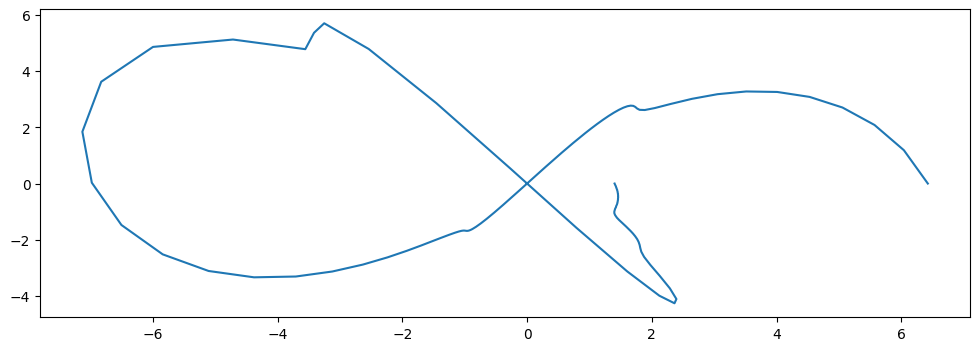

In [167]:
plot_curve(q)

In [168]:
def numpy_nans(dim, *args, **kwargs):
    arr = np.empty(dim, *args, **kwargs)
    arr.fill(np.nan)
    return arr

In [169]:
def reparametrize(q, r, network, loss, optimizer, iterations, logger):
    # Evaluate initial error
    logger.start()
    error = numpy_nans(iterations+1)
    error[0] = loss(network)
    
    for i in range(iterations):
        # Zero gradient buffers
        optimizer.zero_grad()
        
        # Compute current loss and gradients
        l = loss(network)
        l.backward()
        
#         # Update optimizer if using scheduler
#         if scheduler is not None:
#             scheduler.step(l)
            
        # Update parameters
        optimizer.step()
        error[i+1] = l.item()
        network.project()

        logger.log(i, l)
    
    logger.stop()
    return error

In [170]:
rn.parameters()

<generator object Module.parameters at 0x7f0d01543740>

In [171]:
c1 = Infinity
γ = LogStepDiff
c2 = c1.compose(γ)

q = Qmap(c2)
r = Qmap(c1)

rn = ReparametrizationNetwork(nn.ModuleList([PalaisLayer(5), PalaisLayer(5)]))

myloss = ShapeDistance(q, r)
reparametrize(q, r, rn, myloss, torch.optim.SGD(rn.parameters(), lr=1e-4, momentum=0.5), 500, Logger(5))

[Iter     1] loss: 2.35562
[Iter     6] loss: 2.10980
[Iter    11] loss: 1.90760
[Iter    16] loss: 1.80298
[Iter    21] loss: 1.74893
[Iter    26] loss: 1.71357
[Iter    31] loss: 1.68411
[Iter    36] loss: 1.65652
[Iter    41] loss: 1.62967
[Iter    46] loss: 1.60324
[Iter    51] loss: 1.57707
[Iter    56] loss: 1.55116
[Iter    61] loss: 1.52552
[Iter    66] loss: 1.50010
[Iter    71] loss: 1.47490
[Iter    76] loss: 1.44995
[Iter    81] loss: 1.42514
[Iter    86] loss: 1.40054
[Iter    91] loss: 1.37609
[Iter    96] loss: 1.35173
[Iter   101] loss: 1.32742
[Iter   106] loss: 1.30310
[Iter   111] loss: 1.27880
[Iter   116] loss: 1.25440
[Iter   121] loss: 1.22989
[Iter   126] loss: 1.20509
[Iter   131] loss: 1.17995
[Iter   136] loss: 1.15428
[Iter   141] loss: 1.12810
[Iter   146] loss: 1.10112
[Iter   151] loss: 1.07320
[Iter   156] loss: 1.04410
[Iter   161] loss: 1.01360
[Iter   166] loss: 0.98156
[Iter   171] loss: 0.94790
[Iter   176] loss: 0.91252
[Iter   181] loss: 0.87574
[

array([2.35562301, 2.35562301, 2.32212806, 2.27323055, 2.21844411,
       2.16298246, 2.109797  , 2.0601871 , 2.01515174, 1.97464502,
       1.93893981, 1.90760398, 1.88030636, 1.85657859, 1.83616066,
       1.81841469, 1.80298436, 1.78949773, 1.77761889, 1.76707506,
       1.75757444, 1.74893105, 1.740942  , 1.73359716, 1.72662306,
       1.71996021, 1.71356559, 1.70741391, 1.70142877, 1.69552779,
       1.68977606, 1.68410993, 1.67849183, 1.67292285, 1.66742945,
       1.66198826, 1.65651584, 1.65113831, 1.64576316, 1.64042878,
       1.63503754, 1.62966609, 1.6244247 , 1.6190989 , 1.61376512,
       1.60848403, 1.60324168, 1.59799802, 1.59275019, 1.58756042,
       1.58228755, 1.57706654, 1.57187223, 1.56670225, 1.56150007,
       1.55631316, 1.55115557, 1.54603148, 1.54084015, 1.53573573,
       1.53061938, 1.52551937, 1.5203892 , 1.51533997, 1.51026118,
       1.50514972, 1.50010443, 1.49505186, 1.49001265, 1.48489225,
       1.47987354, 1.47490454, 1.46984136, 1.46486807, 1.45991

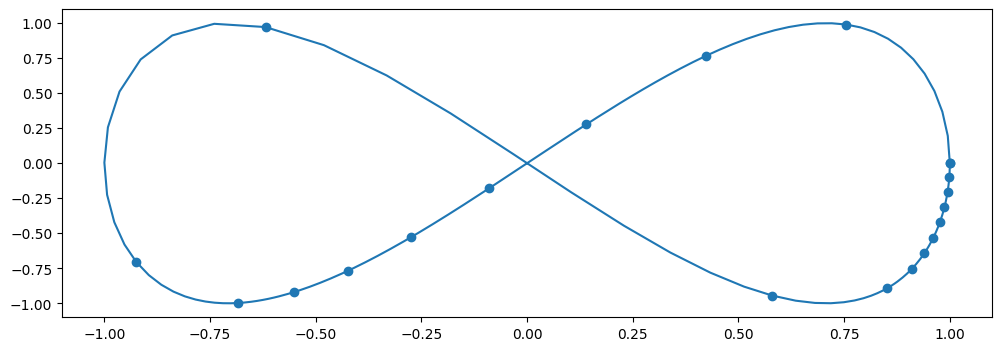

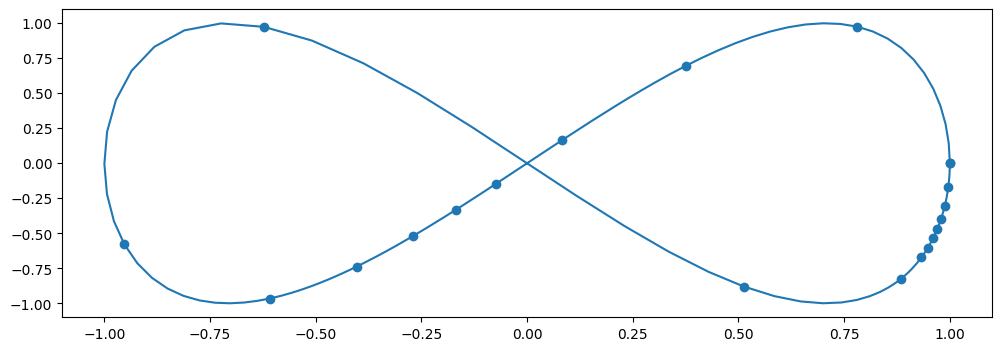

In [165]:
with torch.no_grad():
    plot_curve(c2, dotpoints=21)
    plot_curve(c1.compose(rn), dotpoints=21)